In [1]:
#Import libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import numpy as np
import math

import tensorflow as tf
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle as pk
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KernelDensity 
from scipy import integrate
import scipy.stats
import shap
import seaborn as sns
# sns.set(style="white")
# sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

/home/nukpezah/anaconda3/envs/tf2_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import Data

In [14]:
#Import data has cell area, aspect ratio,circularity, average of motility and stiffness per cell line per substrate, and joined on cell line cell subtrate proteomics data
morphology_cells_final_list = pd.read_csv('morphology_frame_red_proteomic_allgenes.txt')

In [15]:
#Data imported consists of the cell type, substrate and stiffness with gausian noise (with mean average stiffness) added to average stiffness per cell line per substrate 
#in order to have in cell line, in substrate variation variation. Standard deviation of Gaussian noise was standard deviation of cell sitffness per cell line across in cell line substrates
df_young_modulus_cells_final_list = pd.read_csv("./young_modulus_gaussian_cells_final_list.csv")
df_young_modulus_cells_final_list.drop(['Unnamed: 0'],axis=1,inplace = True)
df_young_modulus_cells_final_list.head()

,cl_id,condition_id,young_modulus
0,22rv1,30kcol,4017.777053
1,22rv1,30kcol,3378.960363
2,22rv1,30kcol,3825.577352
3,22rv1,30kcol,3440.764115
4,22rv1,30kcol,3580.165897


In [16]:
x_young_modulus = np.linspace(morphology_cells_final_list['young_modulus'].min(), morphology_cells_final_list['young_modulus'].max(),5000)


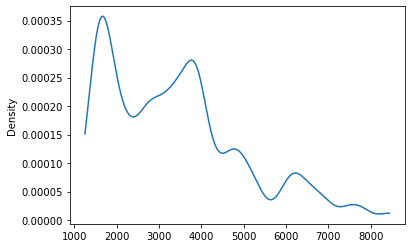

In [17]:
ax_young_modulus = morphology_cells_final_list['young_modulus'].plot.kde(ind= x_young_modulus)

In [20]:
#list of cell lines
list_cells = ['skmel2',
               'a375',
              'wm2664',
              'rwpe1',
              '22rv1',
              'panc1',
              'skov3',
              'ncih2126',
               'nl20',
              'hct116',
               'ht29',
              'sw620',
              'sw480',
              't47d',
              'mcf7',
              'mdamb231',
              'hterthme1',
              'mcf10ajsb',
               'u87',
              't98g']

In [22]:
#formatting cell names
list_cells2 = ['SK-MEL-2','A375','WM266-4','RWPE-1','22Rv1','Panc-1','SK-OV-3','NCI-H2126','NL20', 'HCT116',\
              'HT-29','SW620','SW480','T-47D','MCF7','MDA-MB-231','HTERT-HME1','MCF10A-JSB','U-87','T98G']
tissue_list =['Skin','Skin','Skin','Prostate','Prostate','Pancreas','Ovary','Lung','Lung','Colon',\
             'Colon','Colon','Colon','Breast','Breast','Breast','Breast','Breast','Brain','Brain']

cell_map_dic = {}
cell_map_dic['skmel2'] = 'SK-MEL-2'
cell_map_dic['a375']= 'A375'
cell_map_dic['wm2664']= 'WM266-4'
cell_map_dic['rwpe1']= 'RWPE-1'
cell_map_dic['22rv1']= '22Rv1'
cell_map_dic['panc1']= 'Panc-1'
cell_map_dic['skov3']= 'SK-OV-3'
cell_map_dic['ncih2126']= 'NCI-H2126'
cell_map_dic['nl20']= 'NL20'
cell_map_dic['hct116'] = 'HCT116'
cell_map_dic['ht29']= 'HT-29'
cell_map_dic['sw620']= 'SW620'
cell_map_dic['sw480']= 'SW480'
cell_map_dic['t47d']= 'T-47D'
cell_map_dic['mcf7'] = 'MCF7'
cell_map_dic['mdamb231']= 'MDA-MB-231'
cell_map_dic['hterthme1'] = 'HTERT-HME1'
cell_map_dic['mcf10ajsb']= 'MCF10A-JSB'
cell_map_dic['u87'] = 'U-87'
cell_map_dic['t98g'] = 'T98G'

In [23]:
cond_dic_count = {'500paacol':'500paacol_Count','500paafn':'500paafn_Count','30kcol':'30kcol_Count',\
                 '30kfn':'30kfn_Count','hacol':'hacol_Count','hafn':'hafn_Count','glass':'glass_Count'}
cond_list_ord_count = ['500paacol_Count','500paafn_Count','30kcol_Count','30kfn_Count','hacol_Count','hafn_Count','glass_Count']

In [24]:
#calculation of kernel density plots for stiffness
df_kde_young_modulus= pd.DataFrame(ax_young_modulus.get_lines()[0].get_xydata(), columns=['young_modulus_lin','kde_val'])
df_kde_young_modulus= pd.DataFrame(ax_young_modulus.get_lines()[0].get_xydata(), columns=['young_modulus_lin','kde_val'])
dic_young_modulus={}
for j in list(list_cells):
    density = scipy.stats.gaussian_kde(morphology_cells_final_list[morphology_cells_final_list['cl_id']==j]['young_modulus'])
    y_young_modulus= density(x_young_modulus)
    df_young_modulus_new= pd.DataFrame(columns=['young_modulus_lin','kde_val'])
    df_young_modulus_new['young_modulus_lin']= x_young_modulus
    df_young_modulus_new['kde_val']= y_young_modulus

    #df_young_modulus_new.plot(x='young_modulus_lin', y='kde_val', ylabel='density')
    dic_young_modulus[j]= df_young_modulus_new
    dic_young_modulus[j]['kde_val_diff_{}'.format(j)]= -(df_kde_young_modulus['kde_val']- dic_young_modulus[j]['kde_val'])
    dic_young_modulus[j]['kde_val_average']= df_kde_young_modulus['kde_val']



In [28]:
from copy import deepcopy

In [29]:
dic_young_modulus_p1a2 = deepcopy(dic_young_modulus)
for j in list_cells:
    dic_young_modulus_p1a2[j].rename(columns={'kde_val_diff_{}'.format(j):'kde_val_diff_{}'.format(cell_map_dic[j])}, inplace=True)  

Supplementary S2 Figure

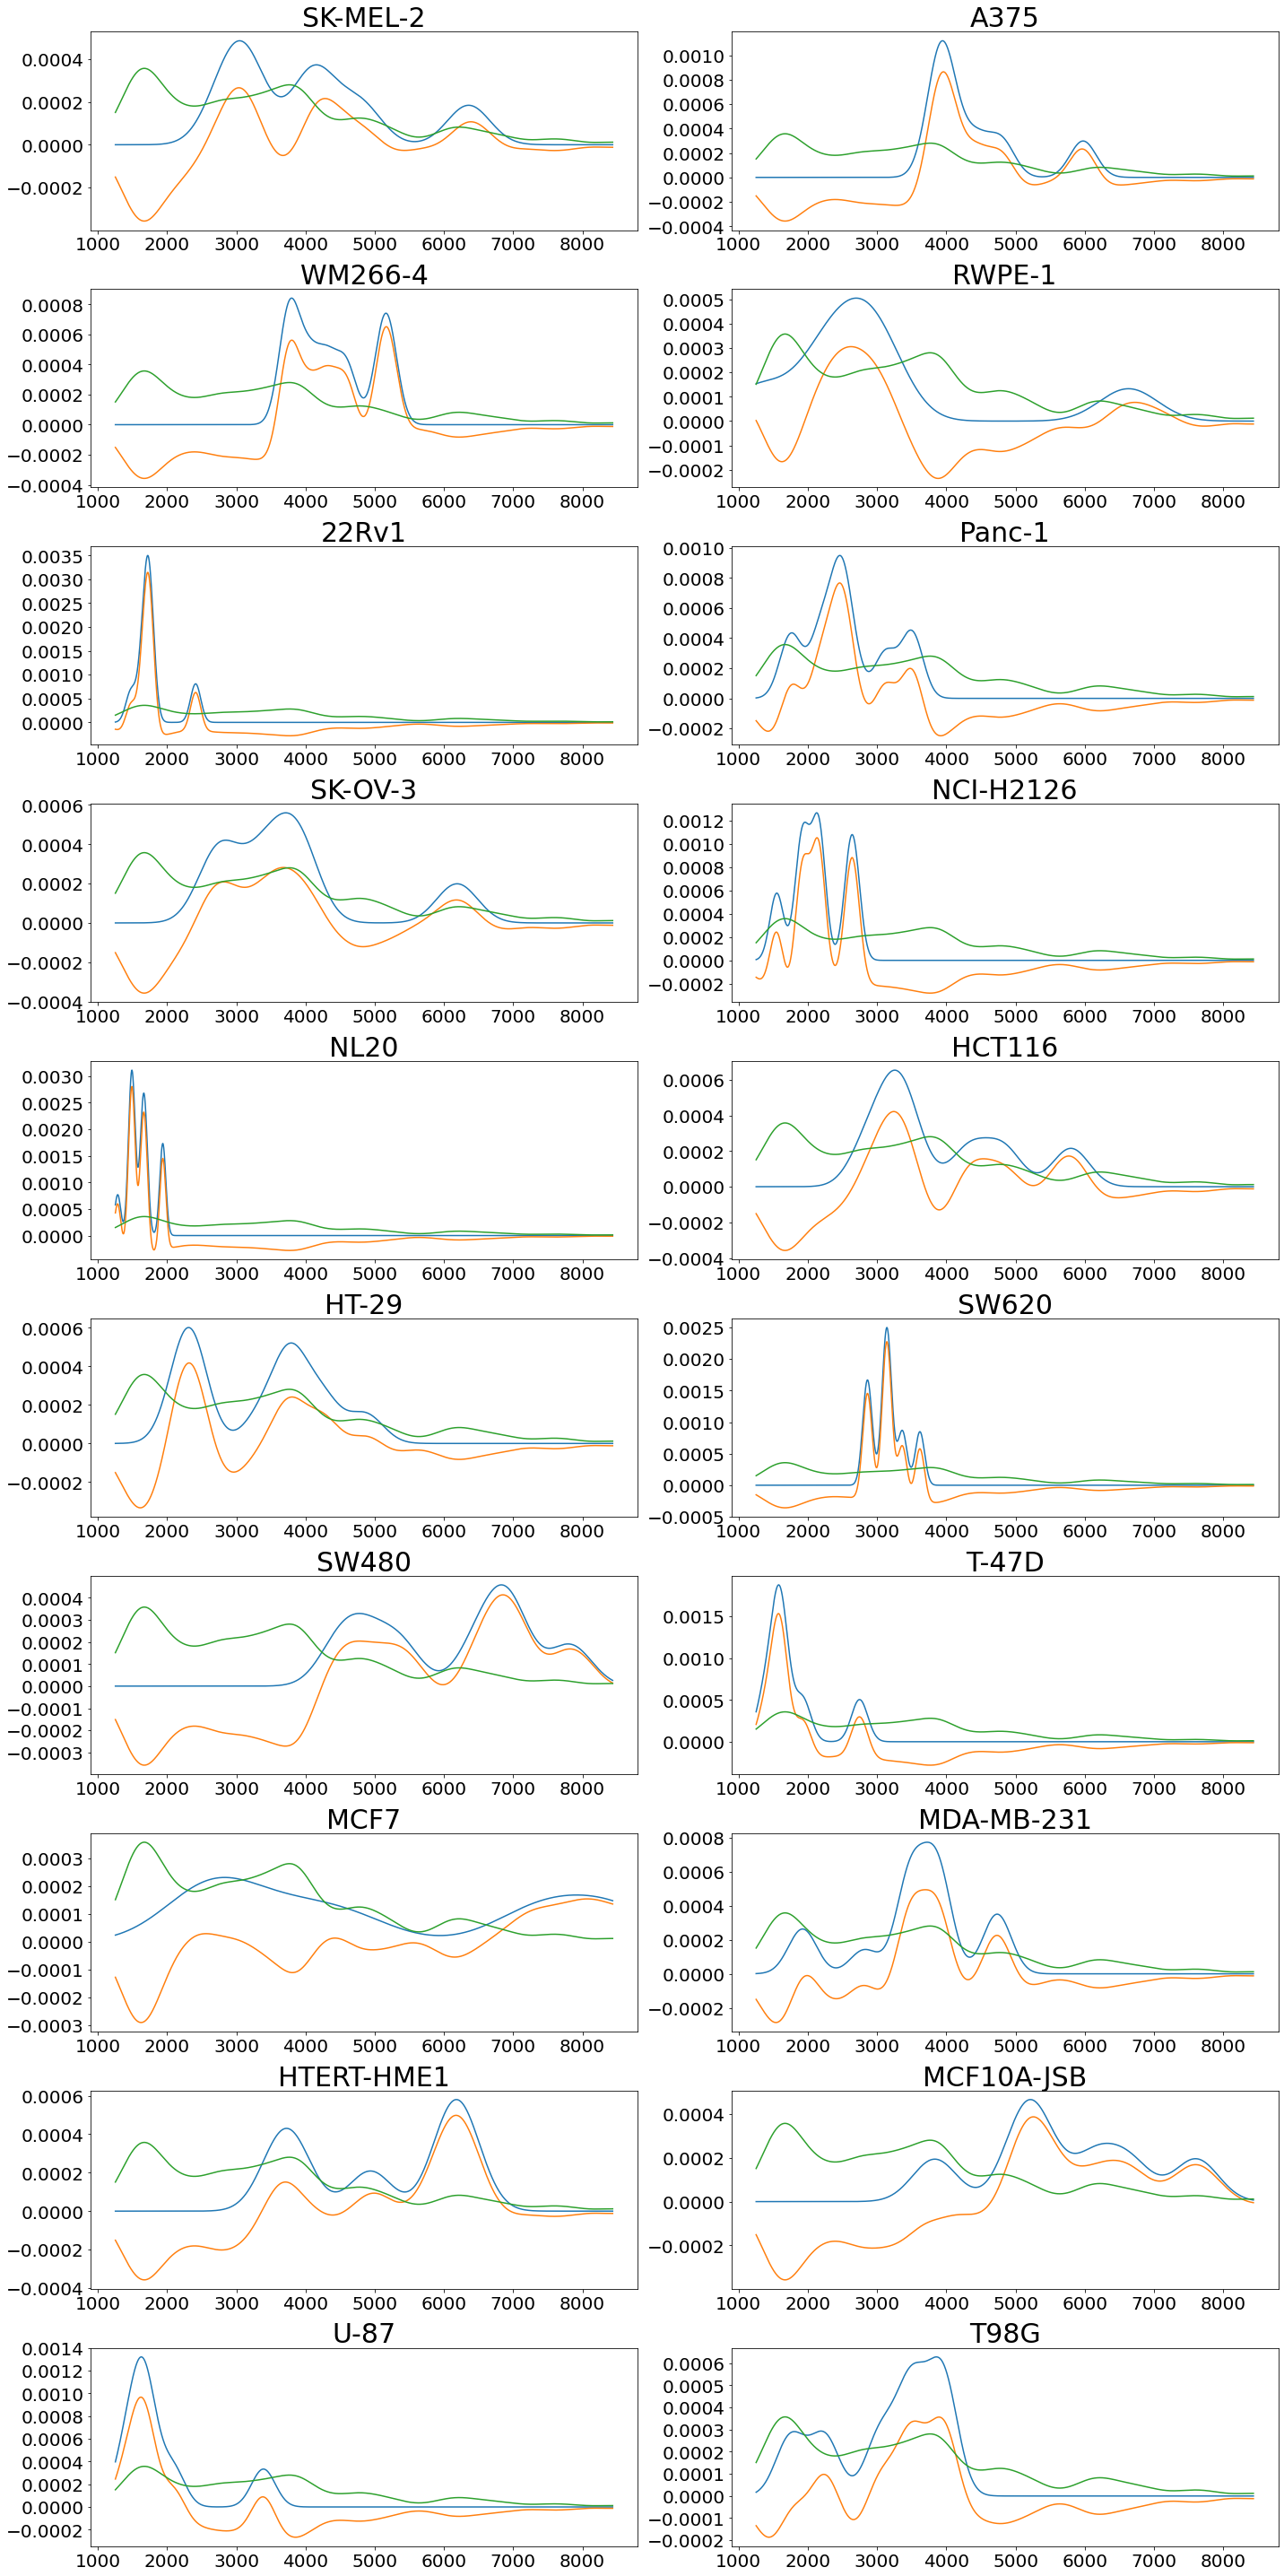

In [31]:
# make a list of all dataframes 
df_list=[]
for j in list_cells:
    df_list.append(dic_young_modulus_p1a2[j])
    
nrow=10
ncol=2
fig, axes = plt.subplots(nrow, ncol)

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(x= 'young_modulus_lin',ax=axes[r,c],fontsize=20, figsize=(20,40), legend= False)
        axes[r,c].xaxis.label.set_visible(False)
        axes[r,c].set_title(cell_map_dic[list_cells[count]], fontsize = 30)

        count+=1
fig.tight_layout()

Figure 1B: Cell stiffness (Pa) for each cell line averaged over respective cells grown on different ECM substrates 

In [33]:
bin_var_ext = ['Average','Low','High']

In [34]:
dic_morph_p1a_values ={}
for m in list_cells:
    u_morph_bin_values =\
    df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== m].copy()
    
    
    for n in ['young_modulus']:
        u_morph_bin_values_median = \
        df_young_modulus_cells_final_list[n].median()
        
        dic_morph_p1a_values['var_{}_{}'.format(m,n)] = pd.DataFrame(index= bin_var_ext, columns= ['Values'])
        dic_morph_p1a_values['var_{}_{}'.format(m,n)].at['Average','Values'] =\
           u_morph_bin_values[n].mean()
        dic_morph_p1a_values['var_{}_{}'.format(m,n)].at['Low','Values'] =\
           u_morph_bin_values[u_morph_bin_values[n]<= u_morph_bin_values_median][n].mean()
        dic_morph_p1a_values['var_{}_{}'.format(m,n)].at['High','Values'] =\
           u_morph_bin_values[u_morph_bin_values[n]> u_morph_bin_values_median][n].mean()

In [44]:

df_p1a_vis_morph_values2 = pd.DataFrame(columns= ['Tissue','Cell','Young_Modulus'])
count = 0
for m, i in enumerate(list_cells):
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== i].copy()
    df_p1a_vis_morph_values2.loc[count,'Tissue'] = tissue_list[m]
    df_p1a_vis_morph_values2.loc[count,'Cell'] = cell_map_dic[i]
    for s, k in enumerate(['young_modulus']):
        df_p1a_vis_morph_values2.loc[count,['Young_Modulus'][s]] = \
            dic_morph_p1a_values['var_{}_{}'.format(i,k)].loc['Average','Values']
        
            
    count+=1
    
df_p1a_vis_morph_values2

,Tissue,Cell,Young_Modulus
0,Skin,SK-MEL-2,8140.765451
1,Skin,A375,8865.063362
2,Skin,WM266-4,8799.164713
3,Prostate,RWPE-1,6055.283512
4,Prostate,22Rv1,3601.781499
5,Pancreas,Panc-1,5151.481248
6,Ovary,SK-OV-3,7490.90328
7,Lung,NCI-H2126,4271.558388
8,Lung,NL20,3237.656682
9,Colon,HCT116,7945.988745


[Text(0, 0.5, 'Skin :  SK-MEL-2'),
 Text(0, 1.5, 'A375'),
 Text(0, 2.5, 'WM266-4'),
 Text(0, 3.5, 'Prostate :  RWPE-1'),
 Text(0, 4.5, '22Rv1'),
 Text(0, 5.5, 'Pancreas :  Panc-1'),
 Text(0, 6.5, 'Ovary :  SK-OV-3'),
 Text(0, 7.5, 'Lung :  NCI-H2126'),
 Text(0, 8.5, 'NL20'),
 Text(0, 9.5, 'Colon :  HCT116'),
 Text(0, 10.5, 'HT-29'),
 Text(0, 11.5, 'SW620'),
 Text(0, 12.5, 'SW480'),
 Text(0, 13.5, 'Breast :  T-47D'),
 Text(0, 14.5, 'MCF7'),
 Text(0, 15.5, 'MDA-MB-231'),
 Text(0, 16.5, 'HTERT-HME1'),
 Text(0, 17.5, 'MCF10A-JSB'),
 Text(0, 18.5, 'Brain :  U-87'),
 Text(0, 19.5, 'T98G')]

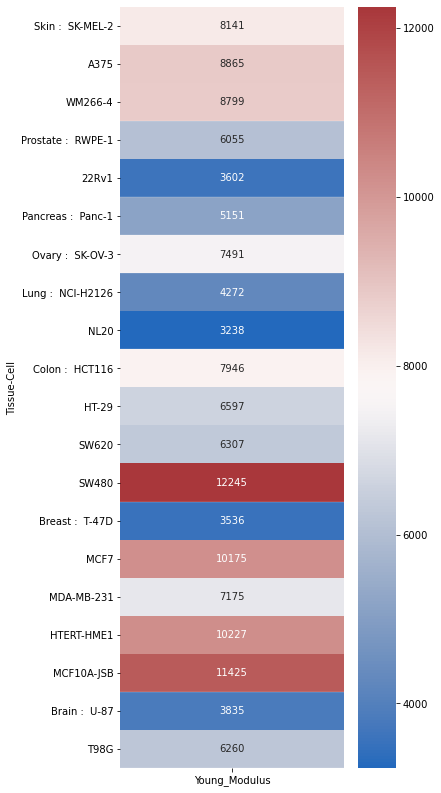

In [45]:
df_p1a_vis_morph_values2 = df_p1a_vis_morph_values2.set_index(['Tissue','Cell'])
df_p1a_vis_morph_values2  = df_p1a_vis_morph_values2.astype('float32')

from collections import OrderedDict
fig, ax = plt.subplots(figsize=(5,14)) 
ax = sns.heatmap(df_p1a_vis_morph_values2  ,annot=True,fmt='.0f', cmap="vlag")

ylabel_mapping = OrderedDict()
for tissue, cell in df_p1a_vis_morph_values2  .index:
    ylabel_mapping.setdefault(tissue, [])
    ylabel_mapping[tissue].append(cell)
    
hline = []
new_ylabels = []
for tissue, cell_list in ylabel_mapping.items():
    cell_list[0] = "{} :  {}".format(tissue, cell_list[0])
    new_ylabels.extend(cell_list)
    
    if hline:
        hline.append(len(cell_list) + hline[-1])
    else:
        hline.append(len(cell_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth= .2)
ax.set_yticklabels(new_ylabels)

Figure 1B:Ratio of cell counts in high vs. low stiffness categories where cutoff used for demarcation is the median of KDE_all

In [46]:
bin_var = ['Low','High']

In [48]:
dic_morph_p1a_count = {}
for m in list_cells:
    u_morph_bin_count =\
    df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== m].copy()
    
    for n in  ['young_modulus']:
        u_morph_bin_count_median = \
        df_young_modulus_cells_final_list[n].median()
        dic_morph_p1a_count['var_{}_{}'.format(m,n)] = pd.DataFrame(index= bin_var, columns= ['Count'])
        dic_morph_p1a_count['var_{}_{}'.format(m,n)].at['Low','Count'] =\
           len(u_morph_bin_count[u_morph_bin_count[n]<= u_morph_bin_count_median])
        dic_morph_p1a_count['var_{}_{}'.format(m,n)].at['High','Count'] =\
           len(u_morph_bin_count[u_morph_bin_count[n]> u_morph_bin_count_median])

In [56]:
df_p1_vis_morph_count = pd.DataFrame(columns=['Tissue','Cell', 'Young_Modulus'])
count = 0
for m,i in enumerate(list_cells):
    
    for j in bin_var:
        df_p1_vis_morph_count.loc[count,'Cell']= '{}_{}'.format(cell_map_dic[i],j)
        df_p1_vis_morph_count.loc[count,'Tissue']= tissue_list[m]
        for s,k in enumerate(['young_modulus']):
            df_p1_vis_morph_count.loc[count,['Young_Modulus'][s]] = \
            dic_morph_p1a_count['var_{}_{}'.format(i,k)].loc[j,'Count']
        count+=1
        


df_p1_vis_morph_count

,Tissue,Cell,Young_Modulus
0,Skin,SK-MEL-2_Low,206
1,Skin,SK-MEL-2_High,496
2,Skin,A375_Low,9
3,Skin,A375_High,692
4,Skin,WM266-4_Low,5
5,Skin,WM266-4_High,695
6,Prostate,RWPE-1_Low,478
7,Prostate,RWPE-1_High,232
8,Prostate,22Rv1_Low,683
9,Prostate,22Rv1_High,0


In [53]:
df_p1_vis_morph_count2 = pd.DataFrame(columns= ['Tissue','Cell', 'Young_Modulus'])
count = 0
for m,i in enumerate(list_cells):
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== i].copy()
    df_p1_vis_morph_count2.loc[count,'Tissue'] = tissue_list[m]
    df_p1_vis_morph_count2.loc[count,'Cell'] = cell_map_dic[i]
    for s, k in enumerate(['young_modulus']):
        u_low =dic_morph_p1a_count['var_{}_{}'.format(i,k)].loc['Low','Count']
        u_high =dic_morph_p1a_count['var_{}_{}'.format(i,k)].loc['High','Count']
        if u_low == 0:
            u_low = u_low +1
        if u_high == 0:
            u_high = u_high +1
        df_p1_vis_morph_count2.loc[count,['Young_Modulus'][s]] = u_high/u_low
            
    count+=1

df_p1_vis_morph_count2

,Tissue,Cell,Young_Modulus
0,Skin,SK-MEL-2,2.407767
1,Skin,A375,76.888889
2,Skin,WM266-4,139.0
3,Prostate,RWPE-1,0.485356
4,Prostate,22Rv1,0.001464
5,Pancreas,Panc-1,0.237705
6,Ovary,SK-OV-3,1.756
7,Lung,NCI-H2126,0.001429
8,Lung,NL20,0.000676
9,Colon,HCT116,2.712042


[Text(0, 0.5, 'Skin :  SK-MEL-2'),
 Text(0, 1.5, 'A375'),
 Text(0, 2.5, 'WM266-4'),
 Text(0, 3.5, 'Prostate :  RWPE-1'),
 Text(0, 4.5, '22Rv1'),
 Text(0, 5.5, 'Pancreas :  Panc-1'),
 Text(0, 6.5, 'Ovary :  SK-OV-3'),
 Text(0, 7.5, 'Lung :  NCI-H2126'),
 Text(0, 8.5, 'NL20'),
 Text(0, 9.5, 'Colon :  HCT116'),
 Text(0, 10.5, 'HT-29'),
 Text(0, 11.5, 'SW620'),
 Text(0, 12.5, 'SW480'),
 Text(0, 13.5, 'Breast :  T-47D'),
 Text(0, 14.5, 'MCF7'),
 Text(0, 15.5, 'MDA-MB-231'),
 Text(0, 16.5, 'HTERT-HME1'),
 Text(0, 17.5, 'MCF10A-JSB'),
 Text(0, 18.5, 'Brain :  U-87'),
 Text(0, 19.5, 'T98G')]

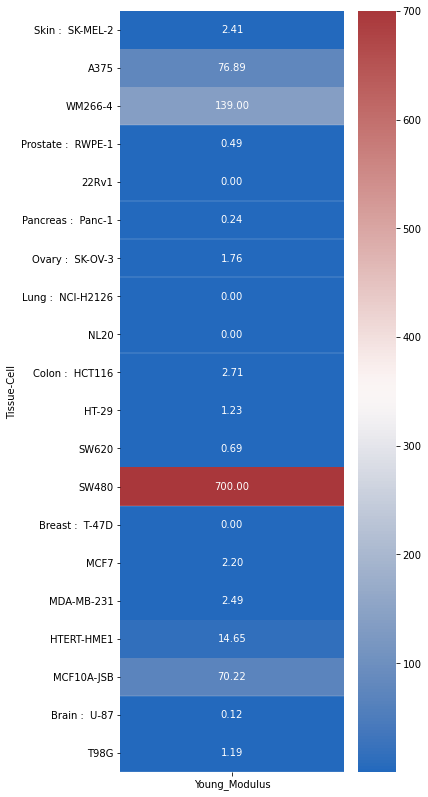

In [54]:
df_p1_vis_morph_count2 = df_p1_vis_morph_count2 .set_index(['Tissue','Cell'])
df_p1_vis_morph_count2  = df_p1_vis_morph_count2 .astype('float32')

from collections import OrderedDict
fig, ax = plt.subplots(figsize=(5,14)) 
ax = sns.heatmap(df_p1_vis_morph_count2 ,annot=True,fmt='.2f', cmap="vlag")

ylabel_mapping = OrderedDict()
for tissue, cell in df_p1_vis_morph_count2 .index:
    ylabel_mapping.setdefault(tissue, [])
    ylabel_mapping[tissue].append(cell)
    
hline = []
new_ylabels = []
for tissue, cell_list in ylabel_mapping.items():
    cell_list[0] = "{} :  {}".format(tissue, cell_list[0])
    new_ylabels.extend(cell_list)
    
    if hline:
        hline.append(len(cell_list) + hline[-1])
    else:
        hline.append(len(cell_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth= .2)
ax.set_yticklabels(new_ylabels)

Figure 1C:  Average cell stiffness (Pa) for each cell line on each of the 7 ECM substrates. 

In [57]:
cond_list_ord = ['500paacol','500paafn','30kcol','30kfn','hacol','hafn','glass']

In [58]:
dic_young_modulus_values = {}
for m in list_cells:
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== m].copy()
    young_modulus_med_cell_p1a =u_df_bin_count['young_modulus'].median()
    for n in  cond_list_ord:
        u_df_bin_count_cond = u_df_bin_count[u_df_bin_count['condition_id']==n].copy()
        dic_young_modulus_values['var_{}_{}'.format(m,n)] = pd.DataFrame(index= bin_var_ext, columns= ['Values'])
        dic_young_modulus_values['var_{}_{}'.format(m,n)].at['Average','Values'] =\
           u_df_bin_count_cond['young_modulus'].mean()
        dic_young_modulus_values['var_{}_{}'.format(m,n)].at['Low','Values'] =\
           u_df_bin_count_cond[u_df_bin_count_cond['young_modulus']<= young_modulus_med_cell_p1a]['young_modulus'].mean()
        dic_young_modulus_values['var_{}_{}'.format(m,n)].at['High','Values'] =\
           u_df_bin_count_cond[u_df_bin_count_cond['young_modulus'] > young_modulus_med_cell_p1a]['young_modulus'].mean()
               
        

In [59]:
df_p3_vis_young_modulus_values2 = pd.DataFrame(columns= ['Tissue','Cell']+cond_list_ord)
count = 0
for m, i in enumerate(list_cells):
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== i].copy()
    df_p3_vis_young_modulus_values2.loc[count,'Tissue'] = tissue_list[m]
    df_p3_vis_young_modulus_values2.loc[count,'Cell'] = cell_map_dic[i]
    for k in cond_list_ord:
        df_p3_vis_young_modulus_values2.loc[count,k] = \
            dic_young_modulus_values['var_{}_{}'.format(i,k)].loc['Average','Values']
        
            
    count+=1
    
df_p3_vis_young_modulus_values2

,Tissue,Cell,500paacol,500paafn,30kcol,30kfn,hacol,hafn,glass
0,Skin,SK-MEL-2,6329.884919,5981.753277,8729.42874,8055.493988,5479.253241,9639.244095,12815.023821
1,Skin,A375,8181.688824,7731.499827,9726.208723,7932.532502,8734.493909,7829.271807,11926.581686
2,Skin,WM266-4,7455.026193,8057.922054,10223.130294,7549.412881,8665.29533,9208.534448,10434.83179
3,Prostate,RWPE-1,4434.905401,6109.098831,4735.04329,5301.111902,2563.083785,6151.882499,13173.230377
4,Prostate,22Rv1,3515.381647,2977.149958,3495.053004,3426.108781,3294.820188,3513.144406,4840.476483
5,Pancreas,Panc-1,6237.951147,5384.036327,5067.282062,3450.184641,4391.626922,7032.103251,4949.92054
6,Ovary,SK-OV-3,5239.139483,6554.978128,5618.94017,6882.499144,7932.492072,7749.815059,12173.480906
7,Lung,NCI-H2126,4272.021679,5202.141102,3799.516071,4300.176093,3083.271736,3878.451295,5365.330741
8,Lung,NL20,2945.910906,3878.346888,3031.023935,3276.106616,2563.625485,2984.483637,3390.244356
9,Colon,HCT116,5666.528689,11499.067201,9558.84061,8748.761854,6640.012484,6987.503281,6658.117232


In [61]:
df_p3_vis_young_modulus_values2 = df_p3_vis_young_modulus_values2.set_index(['Tissue','Cell'])
df_p3_vis_young_modulus_values2 = df_p3_vis_young_modulus_values2.rename(columns= {'500paacol':'500pacol','500paafn':'500pafn','30kcol':'30kpacol','30kfn':'30kpafn'})

[Text(0, 0.5, 'Skin :  SK-MEL-2'),
 Text(0, 1.5, 'A375'),
 Text(0, 2.5, 'WM266-4'),
 Text(0, 3.5, 'Prostate :  RWPE-1'),
 Text(0, 4.5, '22Rv1'),
 Text(0, 5.5, 'Pancreas :  Panc-1'),
 Text(0, 6.5, 'Ovary :  SK-OV-3'),
 Text(0, 7.5, 'Lung :  NCI-H2126'),
 Text(0, 8.5, 'NL20'),
 Text(0, 9.5, 'Colon :  HCT116'),
 Text(0, 10.5, 'HT-29'),
 Text(0, 11.5, 'SW620'),
 Text(0, 12.5, 'SW480'),
 Text(0, 13.5, 'Breast :  T-47D'),
 Text(0, 14.5, 'MCF7'),
 Text(0, 15.5, 'MDA-MB-231'),
 Text(0, 16.5, 'HTERT-HME1'),
 Text(0, 17.5, 'MCF10A-JSB'),
 Text(0, 18.5, 'Brain :  U-87'),
 Text(0, 19.5, 'T98G')]

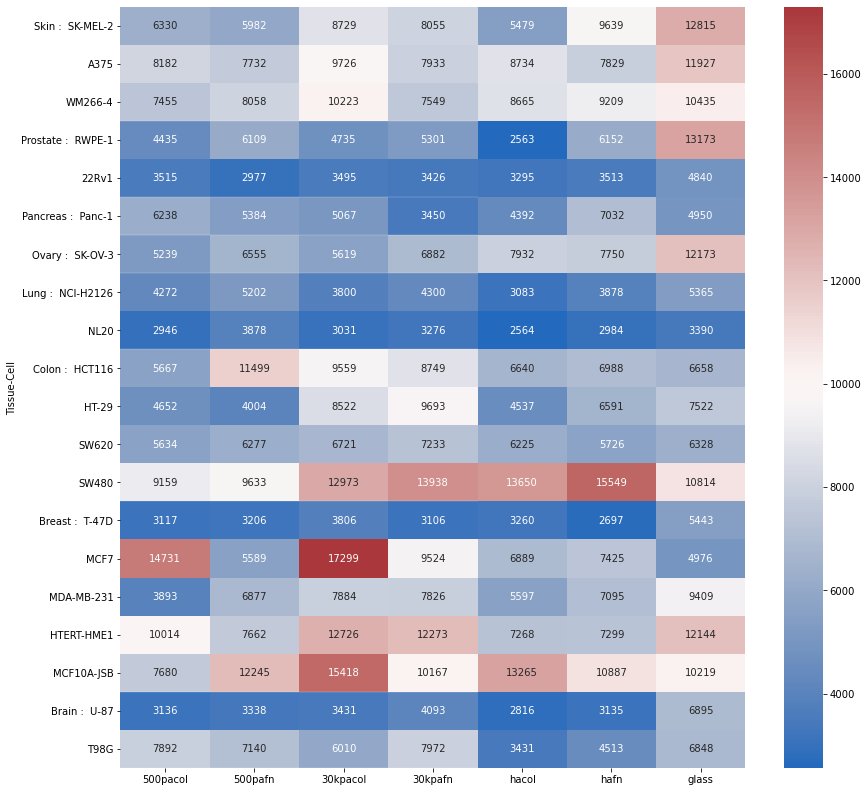

In [62]:
# df_p3_vis_young_modulus_values2 = df_p3_vis_young_modulus_values2.set_index(['Tissue','Cell'])
df_p3_vis_young_modulus_values2 = df_p3_vis_young_modulus_values2.astype('float32')
from collections import OrderedDict
fig, ax = plt.subplots(figsize=(14,14)) 
ax = sns.heatmap(df_p3_vis_young_modulus_values2,annot=True,fmt='.0f', cmap="vlag")

ylabel_mapping = OrderedDict()
for tissue, cell in df_p3_vis_young_modulus_values2.index:
    ylabel_mapping.setdefault(tissue, [])
    ylabel_mapping[tissue].append(cell)
    
hline = []
new_ylabels = []
for tissue, cell_list in ylabel_mapping.items():
    cell_list[0] = "{} :  {}".format(tissue, cell_list[0])
    new_ylabels.extend(cell_list)
    
    if hline:
        hline.append(len(cell_list) + hline[-1])
    else:
        hline.append(len(cell_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth= .2)
ax.set_yticklabels(new_ylabels)

Figure 1D: Ratio of cell counts in high vs. low stiffness categories where cutoff used for demarcation is the median of the cell type specific KDE of cell stiffness over all substrates.

In [63]:
dic_young_modulus_count = {}
for m in list_cells:
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== m].copy()
    young_modulus_med_cell_p1a =u_df_bin_count['young_modulus'].median()
    for n in  cond_list_ord:
        u_df_bin_count_cond = u_df_bin_count[u_df_bin_count['condition_id']==n].copy()
        dic_young_modulus_count['var_{}_{}'.format(m,n)] = pd.DataFrame(index= bin_var, columns= ['Count'])
        dic_young_modulus_count['var_{}_{}'.format(m,n)].at['Low','Count'] =\
           len(u_df_bin_count_cond[u_df_bin_count_cond['young_modulus']<= young_modulus_med_cell_p1a])
        dic_young_modulus_count['var_{}_{}'.format(m,n)].at['High','Count'] =\
           len(u_df_bin_count_cond[u_df_bin_count_cond['young_modulus'] > young_modulus_med_cell_p1a])
            

In [64]:
df_p3_vis_young_modulus_count = pd.DataFrame(columns= ['Cell']+cond_list_ord)
count = 0
for i in list_cells:
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== i].copy()
    for j in bin_var:
        df_p3_vis_young_modulus_count.loc[count,'Cell']= '{}_{}'.format(cell_map_dic[i],j)
        for k in cond_list_ord:
            df_p3_vis_young_modulus_count.loc[count,k] = \
            dic_young_modulus_count['var_{}_{}'.format(i,k)].loc[j,'Count']
        count+=1
        


df_p3_vis_young_modulus_count

,Cell,500paacol,500paafn,30kcol,30kfn,hacol,hafn,glass
0,SK-MEL-2_Low,93,94,19,42,99,4,0
1,SK-MEL-2_High,8,6,81,58,2,96,100
2,A375_Low,68,87,2,74,36,84,0
3,A375_High,33,13,98,26,64,16,100
4,WM266-4_Low,98,84,0,98,50,20,0
5,WM266-4_High,2,16,100,2,50,80,100
6,RWPE-1_Low,77,35,66,51,98,28,0
7,RWPE-1_High,23,68,36,52,3,73,100
8,22Rv1_Low,44,80,49,56,76,37,0
9,22Rv1_High,55,1,50,44,27,61,103


In [65]:
df_p3_vis_young_modulus_count2 = pd.DataFrame(columns= ['Tissue','Cell']+cond_list_ord)
count = 0
for m,i in enumerate(list_cells):
    u_df_bin_count = df_young_modulus_cells_final_list[df_young_modulus_cells_final_list['cl_id']== i].copy()
    df_p3_vis_young_modulus_count2.loc[count,'Tissue'] = tissue_list[m]
    df_p3_vis_young_modulus_count2.loc[count,'Cell'] = cell_map_dic[i]
    for k in cond_list_ord:
        u_low =dic_young_modulus_count['var_{}_{}'.format(i,k)].loc['Low','Count']
        u_high =dic_young_modulus_count['var_{}_{}'.format(i,k)].loc['High','Count']
        if u_low == 0:
            u_low = u_low +1
        if u_high == 0:
            u_high = u_high +1
        df_p3_vis_young_modulus_count2.loc[count,k] = u_high/u_low
            
    count+=1

df_p3_vis_young_modulus_count2

,Tissue,Cell,500paacol,500paafn,30kcol,30kfn,hacol,hafn,glass
0,Skin,SK-MEL-2,0.086022,0.06383,4.263158,1.380952,0.020202,24.0,100.0
1,Skin,A375,0.485294,0.149425,49.0,0.351351,1.777778,0.190476,100.0
2,Skin,WM266-4,0.020408,0.190476,100.0,0.020408,1.0,4.0,100.0
3,Prostate,RWPE-1,0.298701,1.942857,0.545455,1.019608,0.030612,2.607143,100.0
4,Prostate,22Rv1,1.25,0.0125,1.020408,0.785714,0.355263,1.648649,103.0
5,Pancreas,Panc-1,71.0,4.25,0.923077,0.009804,0.144444,105.0,0.90566
6,Ovary,SK-OV-3,0.051282,0.485714,0.102041,0.942308,3.545455,2.68,102.0
7,Lung,NCI-H2126,1.173913,99.0,0.190476,1.380952,0.01,0.298701,100.0
8,Lung,NL20,0.09292,284.0,0.282443,1.855556,0.007937,0.171875,5.358974
9,Colon,HCT116,0.009434,101.0,49.0,6.692308,0.176471,0.408451,0.294872


In [66]:
df_p3_vis_young_modulus_count2 = df_p3_vis_young_modulus_count2.rename(columns= {'500paacol':'500pacol','500paafn':'500pafn','30kcol':'30kpacol','30kfn':'30kpafn'})
df_p3_vis_young_modulus_count2 = df_p3_vis_young_modulus_count2.set_index(['Tissue','Cell'])

[Text(0, 0.5, 'Skin :  SK-MEL-2'),
 Text(0, 1.5, 'A375'),
 Text(0, 2.5, 'WM266-4'),
 Text(0, 3.5, 'Prostate :  RWPE-1'),
 Text(0, 4.5, '22Rv1'),
 Text(0, 5.5, 'Pancreas :  Panc-1'),
 Text(0, 6.5, 'Ovary :  SK-OV-3'),
 Text(0, 7.5, 'Lung :  NCI-H2126'),
 Text(0, 8.5, 'NL20'),
 Text(0, 9.5, 'Colon :  HCT116'),
 Text(0, 10.5, 'HT-29'),
 Text(0, 11.5, 'SW620'),
 Text(0, 12.5, 'SW480'),
 Text(0, 13.5, 'Breast :  T-47D'),
 Text(0, 14.5, 'MCF7'),
 Text(0, 15.5, 'MDA-MB-231'),
 Text(0, 16.5, 'HTERT-HME1'),
 Text(0, 17.5, 'MCF10A-JSB'),
 Text(0, 18.5, 'Brain :  U-87'),
 Text(0, 19.5, 'T98G')]

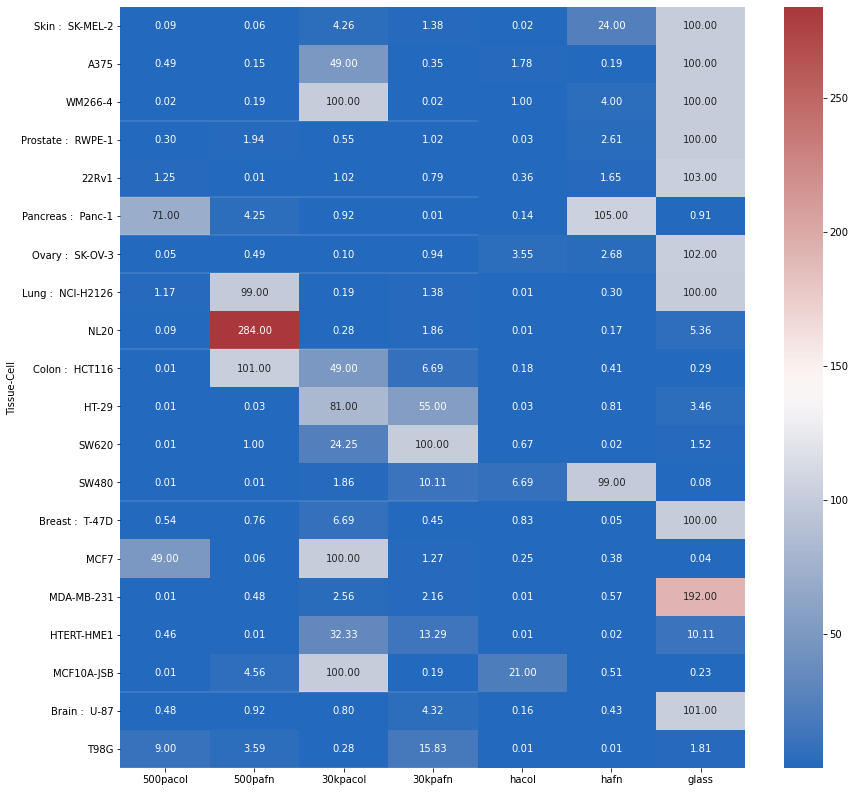

In [67]:
# df_p3_vis_young_modulus_count2 = df_p3_vis_young_modulus_count2.set_index(['Tissue','Cell'])
df_p3_vis_young_modulus_count2 = df_p3_vis_young_modulus_count2.astype('float32')

from collections import OrderedDict
fig, ax = plt.subplots(figsize=(14,14)) 
ax = sns.heatmap(df_p3_vis_young_modulus_count2,annot=True,fmt='.2f', cmap="vlag")

ylabel_mapping = OrderedDict()
for tissue, cell in df_p3_vis_young_modulus_count2.index:
    ylabel_mapping.setdefault(tissue, [])
    ylabel_mapping[tissue].append(cell)
    
hline = []
new_ylabels = []
for tissue, cell_list in ylabel_mapping.items():
    cell_list[0] = "{} :  {}".format(tissue, cell_list[0])
    new_ylabels.extend(cell_list)
    
    if hline:
        hline.append(len(cell_list) + hline[-1])
    else:
        hline.append(len(cell_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth= .2)
ax.set_yticklabels(new_ylabels)

Figure 1E: For each cell line, average value of the ratio of the Young`s Moduli of the cells in moving from one substrate to another as a measure of the cell stiffness  sensitivity to substrate change. (COL fold: 30kPa COL/500Pa COL,  FN fold: 30kPa FN/500Pa FN, HYAL fold: HACOL/HAFN, Glass fold: Glass/500Pa COL, HAFN fold: HAFN/500PA FN, HACOL fold: HACOL/500PA COL)



In [78]:
#data created by taking ratios for col fold, fn fold, hyal fold, glass fold of data
#from df_young_modulus_cells_final_list
fold_list= ['col_fold', 'fn_fold', 'hyal_fold', 'glass_fold', 'hafn_fold', 'hacol_fold']
df_p3_vis_young_modulus_sensitivity_values2= pd.read_csv("./young_modulus_sensitivity_ratios.csv")
df_p3_vis_young_modulus_sensitivity_values2

,Tissue,Cell,col_fold,fn_fold,hyal_fold,glass_fold,hafn_fold,hacol_fold
0,Skin,SK-MEL-2,1.323510,1.317719,0.591297,1.985728,1.567113,0.881678
1,Skin,A375,1.192735,1.033862,1.154208,1.481385,0.986386,1.088429
2,Skin,WM266-4,1.383182,0.940605,0.942008,1.371708,1.136678,1.138145
3,Prostate,RWPE-1,1.147233,0.865610,0.427453,3.099305,0.995973,0.587174
4,Prostate,22Rv1,0.987851,1.164058,0.954589,1.395923,1.182709,0.927659
5,Pancreas,Panc-1,0.808149,0.661280,0.640981,0.800285,1.305693,0.696298
6,Ovary,SK-OV-3,0.992634,1.067332,1.020975,2.270493,1.167016,1.442174
7,Lung,NCI-H2126,0.894096,0.822860,0.780607,1.249965,0.769924,0.722715
8,Lung,NL20,1.029390,0.842230,0.868370,1.151807,0.781589,0.868507
9,Colon,HCT116,1.684126,0.750411,0.939794,1.117828,0.606019,1.140347


[Text(0, 0.5, 'Skin :  SK-MEL-2'),
 Text(0, 1.5, 'A375'),
 Text(0, 2.5, 'WM266-4'),
 Text(0, 3.5, 'Prostate :  RWPE-1'),
 Text(0, 4.5, '22Rv1'),
 Text(0, 5.5, 'Pancreas :  Panc-1'),
 Text(0, 6.5, 'Ovary :  SK-OV-3'),
 Text(0, 7.5, 'Lung :  NCI-H2126'),
 Text(0, 8.5, 'NL20'),
 Text(0, 9.5, 'Colon :  HCT116'),
 Text(0, 10.5, 'HT-29'),
 Text(0, 11.5, 'SW620'),
 Text(0, 12.5, 'SW480'),
 Text(0, 13.5, 'Breast :  T-47D'),
 Text(0, 14.5, 'MCF7'),
 Text(0, 15.5, 'MDA-MB-231'),
 Text(0, 16.5, 'HTERT-HME1'),
 Text(0, 17.5, 'MCF10A-JSB'),
 Text(0, 18.5, 'Brain :  U-87'),
 Text(0, 19.5, 'T98G')]

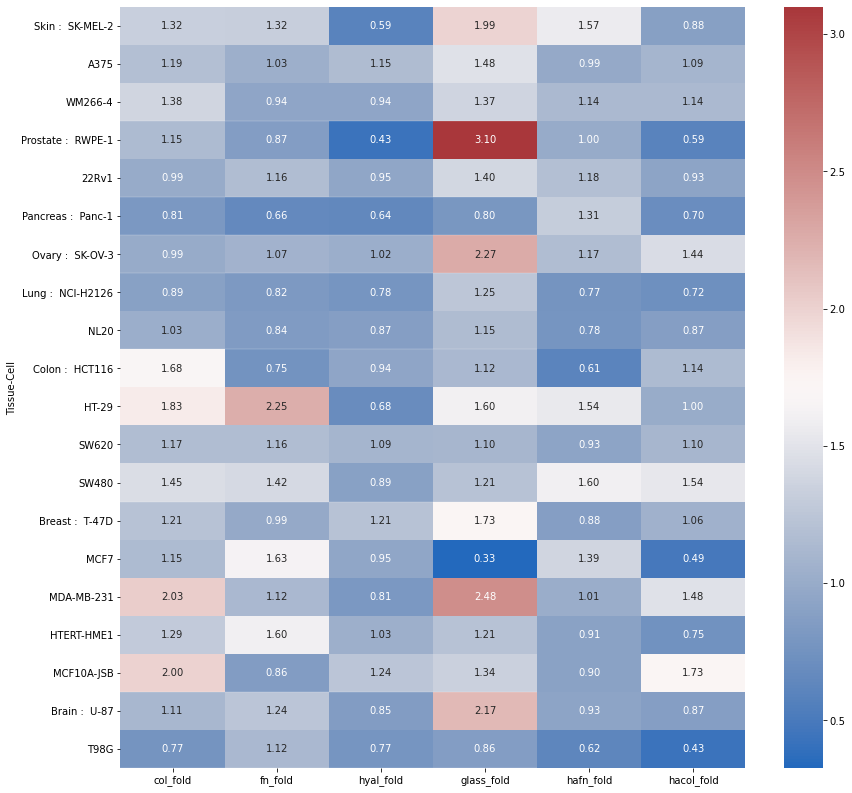

In [79]:
df_p3_vis_young_modulus_sensitivity_values2 = df_p3_vis_young_modulus_sensitivity_values2.set_index(['Tissue','Cell'])
df_p3_vis_young_modulus_sensitivity_values2 = df_p3_vis_young_modulus_sensitivity_values2.astype('float32')
from collections import OrderedDict
fig, ax = plt.subplots(figsize=(14,14)) 
ax = sns.heatmap(df_p3_vis_young_modulus_sensitivity_values2,annot=True,fmt='.2f', cmap="vlag")

ylabel_mapping = OrderedDict()
for tissue, cell in df_p3_vis_young_modulus_sensitivity_values2.index:
    ylabel_mapping.setdefault(tissue, [])
    ylabel_mapping[tissue].append(cell)
    
hline = []
new_ylabels = []
for tissue, cell_list in ylabel_mapping.items():
    cell_list[0] = "{} :  {}".format(tissue, cell_list[0])
    new_ylabels.extend(cell_list)
    
    if hline:
        hline.append(len(cell_list) + hline[-1])
    else:
        hline.append(len(cell_list))


ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth= .2)
ax.set_yticklabels(new_ylabels)

Figure 2B: PCA heatmap of first five principal components (PC1-5) of protein expression levels in low stiffness and high stiffness cells. Pairwise angles between the respective PC1-5 of low and high stiffness cells. 


In [81]:
cyto_skel_list = ['VCL','MYH9','TLN1','TLN2','ACTN1','ACTN3','ACTN4','PLEC','VIM','FLNA',
'FLNB','FLNC','KRT18','GSN','LMNA','LMNB1','LMNB2','ACTG1']
print(len(cyto_skel_list))

18


In [82]:
morph_var = ['cl_id','condition_id']

In [89]:
# young_modulus_median_status is the split into low stiffness and high stiffness using median of young modulus
df_youngmod_janmey_list = morphology_cells_final_list[morph_var + cyto_skel_list + ['young_modulus_median_status']]
df_youngmod_janmey_list.head()

,cl_id,condition_id,VCL,MYH9,TLN1,TLN2,ACTN1,ACTN3,ACTN4,PLEC,...,FLNA,FLNB,FLNC,KRT18,GSN,LMNA,LMNB1,LMNB2,ACTG1,young_modulus_median_status
0,22rv1,30kcol,11.666667,157.0,11.666667,0.0,54.333333,13.333333,211.666667,6.333333,...,13.666667,70.333333,4.333333,49.0,0.0,237.333333,30.0,16.666667,191.0,0
1,22rv1,30kcol,11.666667,157.0,11.666667,0.0,54.333333,13.333333,211.666667,6.333333,...,13.666667,70.333333,4.333333,49.0,0.0,237.333333,30.0,16.666667,191.0,0
2,22rv1,30kcol,11.666667,157.0,11.666667,0.0,54.333333,13.333333,211.666667,6.333333,...,13.666667,70.333333,4.333333,49.0,0.0,237.333333,30.0,16.666667,191.0,0
3,22rv1,30kcol,11.666667,157.0,11.666667,0.0,54.333333,13.333333,211.666667,6.333333,...,13.666667,70.333333,4.333333,49.0,0.0,237.333333,30.0,16.666667,191.0,0
4,22rv1,30kcol,11.666667,157.0,11.666667,0.0,54.333333,13.333333,211.666667,6.333333,...,13.666667,70.333333,4.333333,49.0,0.0,237.333333,30.0,16.666667,191.0,0


In [91]:
X_youngmod_janmey_list_lowstiff = df_youngmod_janmey_list[df_youngmod_janmey_list['young_modulus_median_status']==0][cyto_skel_list]

X_youngmod_janmey_list_highstiff = df_youngmod_janmey_list[df_youngmod_janmey_list['young_modulus_median_status']==1][cyto_skel_list] 

In [92]:
x_lowstiff_janmey_list = StandardScaler().fit_transform(X_youngmod_janmey_list_lowstiff)
x_lowstiff_janmey_list = pd.DataFrame(x_lowstiff_janmey_list, columns = cyto_skel_list)


x_highstiff_janmey_list = StandardScaler().fit_transform(X_youngmod_janmey_list_highstiff)
x_highstiff_janmey_list = pd.DataFrame(x_highstiff_janmey_list, columns = cyto_skel_list)

In [93]:
pcamodel_lowstiff_janmey_list = PCA(n_components=5)
pcamodel_highstiff_janmey_list = PCA(n_components=5)

In [94]:
pca_lowstiff_janmey_list = pcamodel_lowstiff_janmey_list.fit_transform(x_lowstiff_janmey_list)
pca_highstiff_janmey_list = pcamodel_highstiff_janmey_list.fit_transform(x_highstiff_janmey_list)
print(pca_lowstiff_janmey_list.shape)
print(pca_highstiff_janmey_list.shape)

(2884, 5)
(3767, 5)


In [95]:
df_pca_lowstiff_janmey_list = pd.DataFrame(pca_lowstiff_janmey_list)
df_pca_lowstiff_janmey_list.head()

,0,1,2,3,4
0,-3.846148,-1.54854,0.886527,-0.460757,-0.389459
1,-3.846148,-1.54854,0.886527,-0.460757,-0.389459
2,-3.846148,-1.54854,0.886527,-0.460757,-0.389459
3,-3.846148,-1.54854,0.886527,-0.460757,-0.389459
4,-3.846148,-1.54854,0.886527,-0.460757,-0.389459


In [96]:
df_pca_highstiff_janmey_list = pd.DataFrame(pca_highstiff_janmey_list)
df_pca_highstiff_janmey_list.head()

,0,1,2,3,4
0,-3.917711,0.133287,-2.868521,-0.183112,0.175841
1,-3.917711,0.133287,-2.868521,-0.183112,0.175841
2,-3.917711,0.133287,-2.868521,-0.183112,0.175841
3,-3.917711,0.133287,-2.868521,-0.183112,0.175841
4,-3.917711,0.133287,-2.868521,-0.183112,0.175841


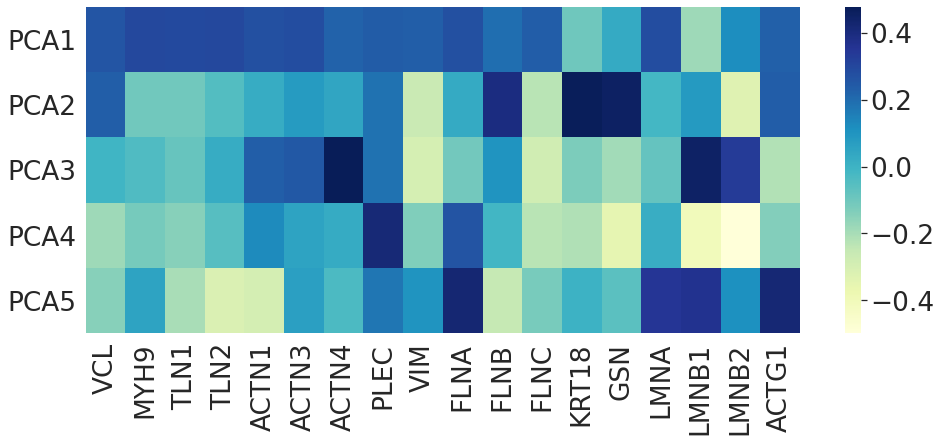

In [98]:
fig, ax = plt.subplots(figsize=(16,6))
sns.set(font_scale=2.4)
ax = sns.heatmap(pcamodel_lowstiff_janmey_list.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel_lowstiff_janmey_list.n_components_+1)],
                 xticklabels=list(x_lowstiff_janmey_list.columns),
                 cbar_kws={"orientation": "vertical"})
#ax.set_aspect("equal")

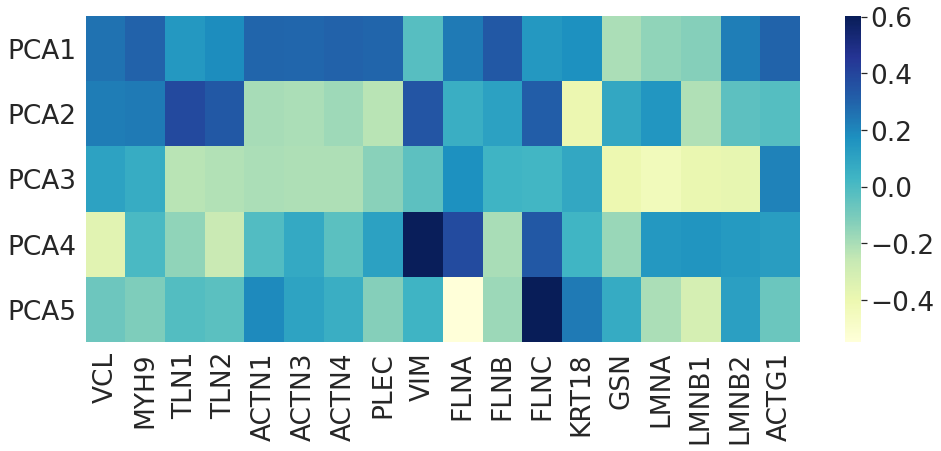

In [99]:
fig, ax = plt.subplots(figsize=(16,6))
sns.set(font_scale=2.4)
ax = sns.heatmap(pcamodel_highstiff_janmey_list.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pcamodel_highstiff_janmey_list.n_components_+1)],
                 xticklabels=list(x_highstiff_janmey_list.columns),
                 cbar_kws={"orientation": "vertical"})
#ax.set_aspect("equal")

In [100]:
vector1 = pcamodel_lowstiff_janmey_list.components_[0]
vector2 = pcamodel_highstiff_janmey_list.components_[0]
vector3 = pcamodel_lowstiff_janmey_list.components_[1]
vector4 =  pcamodel_highstiff_janmey_list.components_[1]
vector5 = pcamodel_lowstiff_janmey_list.components_[2]
vector6 = pcamodel_highstiff_janmey_list.components_[2]
vector7 = pcamodel_lowstiff_janmey_list.components_[3]
vector8 = pcamodel_highstiff_janmey_list.components_[3]
vector9 = pcamodel_lowstiff_janmey_list.components_[4]
vector10 = pcamodel_highstiff_janmey_list.components_[4]

unit_vector1 = vector1 / np.linalg.norm(vector1)
unit_vector2 = vector2 / np.linalg.norm(vector2)

unit_vector3 = vector3 / np.linalg.norm(vector3)
unit_vector4 = vector4 / np.linalg.norm(vector4)

unit_vector5 = vector5 / np.linalg.norm(vector5)
unit_vector6 = vector6 / np.linalg.norm(vector6)

unit_vector7 = vector7 / np.linalg.norm(vector7)
unit_vector8 = vector8 / np.linalg.norm(vector8)

unit_vector9 = vector9 / np.linalg.norm(vector9)
unit_vector10 = vector10 / np.linalg.norm(vector10)

dot_product1 = np.dot(unit_vector1, unit_vector2)
dot_product2 = np.dot(unit_vector3, unit_vector4)
dot_product3 = np.dot(unit_vector5, unit_vector6)
dot_product4 = np.dot(unit_vector7, unit_vector8)
dot_product5 = np.dot(unit_vector9, unit_vector10)
angle1 = np.arccos(dot_product1) #angle in radian
angle2 = np.arccos(dot_product2) #angle in radian
angle3 = np.arccos(dot_product3)
angle4 = np.arccos(dot_product4)
angle5 = np.arccos(dot_product5)

In [101]:
df_pc_angles_janmey_list= pd.DataFrame(columns= ["angle"],index= ["PC1","PC2", "PC3","PC4","PC5"])
df_pc_angles_janmey_list.loc["PC1", 'angle']= math.degrees(angle1)
df_pc_angles_janmey_list.loc["PC2", 'angle']= math.degrees(angle2)
df_pc_angles_janmey_list.loc["PC3",'angle']= math.degrees(angle3)
df_pc_angles_janmey_list.loc["PC4",'angle']= math.degrees(angle4)
df_pc_angles_janmey_list.loc["PC5", 'angle']= math.degrees(angle5)
df_pc_angles_janmey_list

,angle
PC1,40.221303
PC2,112.173936
PC3,118.200939
PC4,89.785003
PC5,121.187684


In [102]:
df_pc_angles_janmey_list_stiff= pd.DataFrame(columns= ["angle"],index= ["PC1","PC2", "PC3","PC4","PC5"])
df_pc_angles_janmey_list_stiff.loc["PC1", 'angle']= 40.221303
df_pc_angles_janmey_list_stiff.loc["PC2", 'angle']= 112.173936
df_pc_angles_janmey_list_stiff.loc["PC3",'angle']= 118.200939
df_pc_angles_janmey_list_stiff.loc["PC4",'angle']= 89.785003
df_pc_angles_janmey_list_stiff.loc["PC5", 'angle']= 121.187684
df_pc_angles_janmey_list_stiff

,angle
PC1,40.221303
PC2,112.173936
PC3,118.200939
PC4,89.785003
PC5,121.187684


<AxesSubplot:>

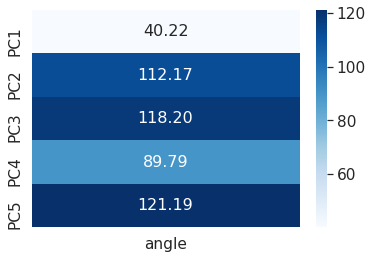

In [103]:
df_pc_angles_janmey_list = df_pc_angles_janmey_list.astype('float64')
sns.set(font_scale=1.4)
sns.heatmap(df_pc_angles_janmey_list,annot=True,fmt='0.2f', cmap='Blues',annot_kws={"size": 16})
#sns.heatmap(df_pc_angles, annot=True, cmap='viridis')

Figure 2C:Shapley values of the selected 18 cytoskeletal related proteins used as features in neural network to predict cell stiffness category (with balanced accuracy of 98% on test set). Histogram showing distribution of protein expressions of the top 5 proteins in low and high cell stiffness categories.


In [104]:
#Histograms of proteins counts
X_youngmod_janmey_list_lowstiff_filt = X_youngmod_janmey_list_lowstiff[['ACTN4', 'MYH9', 'PLEC', 'TLN1', 'VCL']]

X_youngmod_janmey_list_highstiff_filt = X_youngmod_janmey_list_highstiff[['ACTN4', 'MYH9', 'PLEC', 'TLN1', 'VCL']]

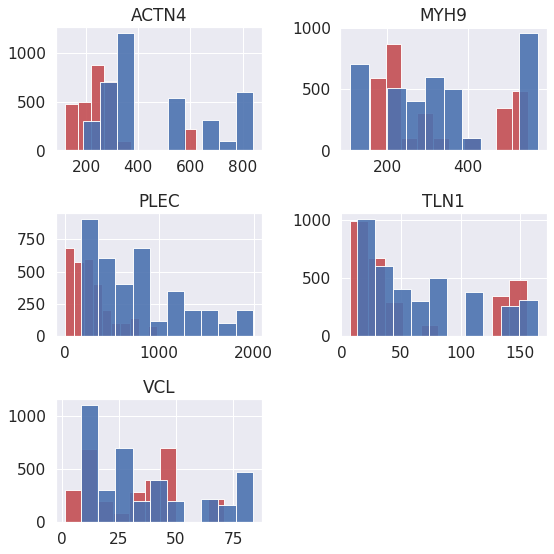

In [105]:
axes1 = X_youngmod_janmey_list_lowstiff_filt.hist(figsize=(8,8),alpha=0.9, color='r')

X_youngmod_janmey_list_highstiff_filt.hist(ax=axes1.ravel()[:5], figsize=(10,10), alpha=0.9,color='b')

plt.tight_layout()
plt.show()

In [116]:
#neural network function

def neural_morph_model(df1, list_input, target_var, descriptor):
    model_morph = Sequential()
    model_morph.add(Dense(5, input_dim=len(list_input), activation='relu'))
    model_morph.add(Dense(1, activation='sigmoid'))
    model_morph.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    X_model_morph = df1[list_input]
    y_model_morph = df1[target_var]
    X_train_model_morph, X_test_model_morph, y_train_model_morph, y_test_model_morph = train_test_split(X_model_morph, y_model_morph,test_size=0.3, random_state=0)
    X_train_data = pd.concat([X_train_model_morph,y_train_model_morph], axis=1)
    X_test_data = pd.concat([X_test_model_morph,y_test_model_morph], axis=1)
    X_train_data.to_csv('X_train_data_{}.csv'.format(descriptor))
    X_test_data.to_csv('X_test_data_{}.csv'.format(descriptor))
    model_morph.fit( X_train_model_morph, y_train_model_morph,batch_size=10, epochs=200, verbose=0, validation_data=( X_test_model_morph,  y_test_model_morph))
    y_test_pred_morph= model_morph.predict(X_test_model_morph)
    loss, acc = model_morph.evaluate(X_test_model_morph, y_test_model_morph, verbose=0)
    model_morph.save('neural_model_morph_{}.hdf5'.format(descriptor))
    print('Test Accuracy: {0:.2f}'.format(acc*100))
    

In [ ]:
#Neural network prediction. Neural network run several times until BACC >= 98% achieved. Final architecture saved and then loaded in next cell for final analysis
neural_morph_model(morphology_cells_final_list, cyto_skel_list,'young_modulus_median_status','janmey_prot_youngmodulus_complex')

In [121]:
neural_model_morph_janmey_prot_youngmodulus2=load_model('neural_model_morph_janmey_prot_youngmodulus_complex.hdf5')

In [125]:
X_train_all= pd.read_csv('X_train_data_janmey_prot_youngmodulus_complex.csv')
X_train = X_train_all[cyto_skel_list]
X_train.head()

,VCL,MYH9,TLN1,TLN2,ACTN1,ACTN3,ACTN4,PLEC,VIM,FLNA,FLNB,FLNC,KRT18,GSN,LMNA,LMNB1,LMNB2,ACTG1
0,80.000000,557.333333,164.333333,17.333333,659.000000,44.000000,648.666667,1007.000000,222.000000,267.000000,1185.000000,105.666667,59.000000,51.333333,566.333333,19.333333,20.333333,392.666667
1,76.333333,530.666667,162.333333,17.333333,661.333333,42.000000,674.333333,1206.000000,208.000000,266.333333,903.666667,111.000000,51.666667,33.000000,557.000000,16.333333,15.666667,382.000000
2,20.000000,366.333333,53.333333,1.666667,159.333333,23.333333,323.333333,672.666667,528.000000,302.000000,386.666667,50.333333,0.000000,7.666667,634.666667,25.000000,12.333333,338.333333
3,1.333333,228.333333,7.000000,0.000000,64.000000,11.666667,119.333333,112.666667,40.333333,58.666667,65.666667,0.666667,21.333333,2.666667,405.000000,10.000000,1.000000,205.333333
4,9.666667,358.333333,13.000000,0.000000,908.333333,65.666667,839.666667,1990.666667,77.000000,209.666667,529.666667,21.333333,467.333333,7.333333,628.333333,36.000000,25.000000,462.333333


In [126]:
X_train_array = X_train.values
X_train_array

array([[ 80.        , 557.33333333, 164.33333333, ...,  19.33333333,
         20.33333333, 392.66666667],
       [ 76.33333333, 530.66666667, 162.33333333, ...,  16.33333333,
         15.66666667, 382.        ],
       [ 20.        , 366.33333333,  53.33333333, ...,  25.        ,
         12.33333333, 338.33333333],
       ...,
       [ 64.66666667, 547.33333333, 117.33333333, ...,  19.33333333,
         15.66666667, 364.        ],
       [ 13.        , 293.66666667,  32.        , ...,  25.66666667,
         15.        , 351.        ],
       [  6.33333333, 182.66666667,  19.33333333, ...,  17.        ,
          7.66666667, 200.33333333]])

In [127]:
#Shapley analysis
e2 = shap.DeepExplainer(neural_model_morph_janmey_prot_youngmodulus2, X_train_array)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


In [131]:
X_test_all= pd.read_csv('X_test_data_janmey_prot_youngmodulus_complex.csv')
X_test = X_test_all[cyto_skel_list]
X_test_array = X_test.values

In [132]:
shap_values2 = e2.shap_values(X_test_array)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


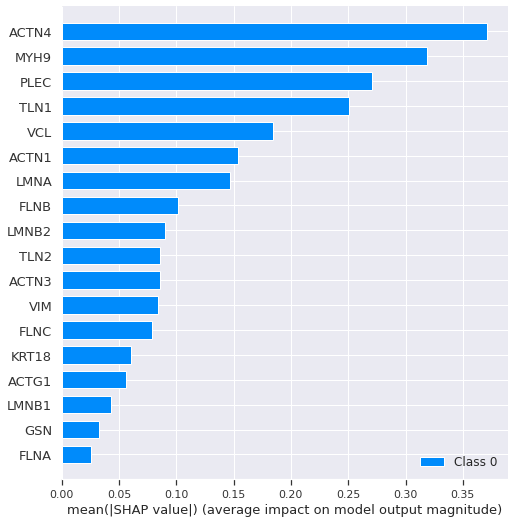

In [133]:
shap.summary_plot(shap_values2, X_test, feature_names=X_train.columns);